In [1]:
'''Calibrating Camera'''
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

objpoints=[]
imgpoints=[]

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

filenames=glob.glob('camera_cal/calibration*.jpg')
for filename in filenames:
    img=cv2.imread(filename)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        # Draw and display the corners
        objpoints.append(objp)
        imgpoints.append(corners)
        #draw_img=cv2.drawChessboardCorners(gray, (nx, ny), corners, ret)
        #plt.imshow(draw_img)
        #cv2.imshow('img', draw_img)
        #cv2.waitKey(500)
        
#cv2.destroyAllWindows()


# use one image to performs the camera calibration
fname = 'camera_cal/calibration1.jpg'
img = cv2.imread(fname)
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[::-1], None, None)

#print(mtx)

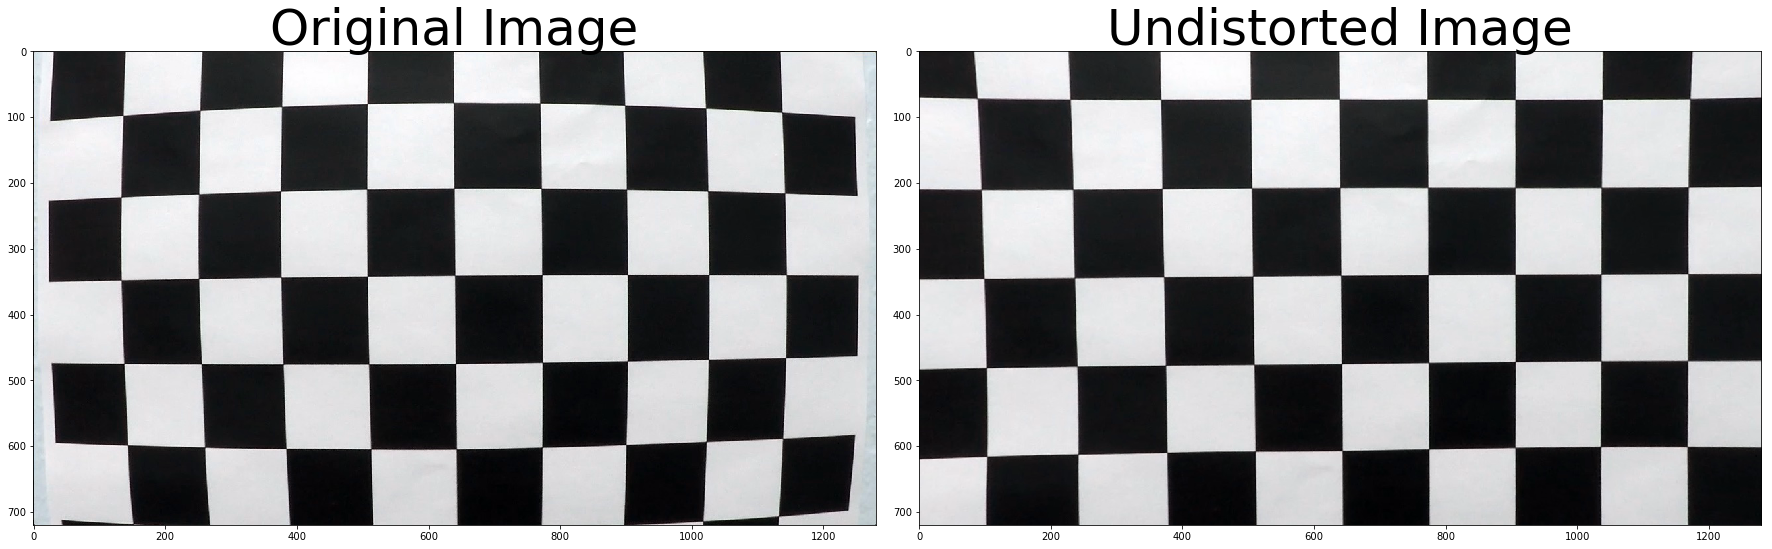

In [2]:
#test image distortion correction 
fname1 = 'camera_cal/calibration1.jpg'
img = cv2.imread(fname)
undistorted=cv2.undistort(img, mtx, dist, None, mtx)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/Undistorted_chess.png')#savefig method

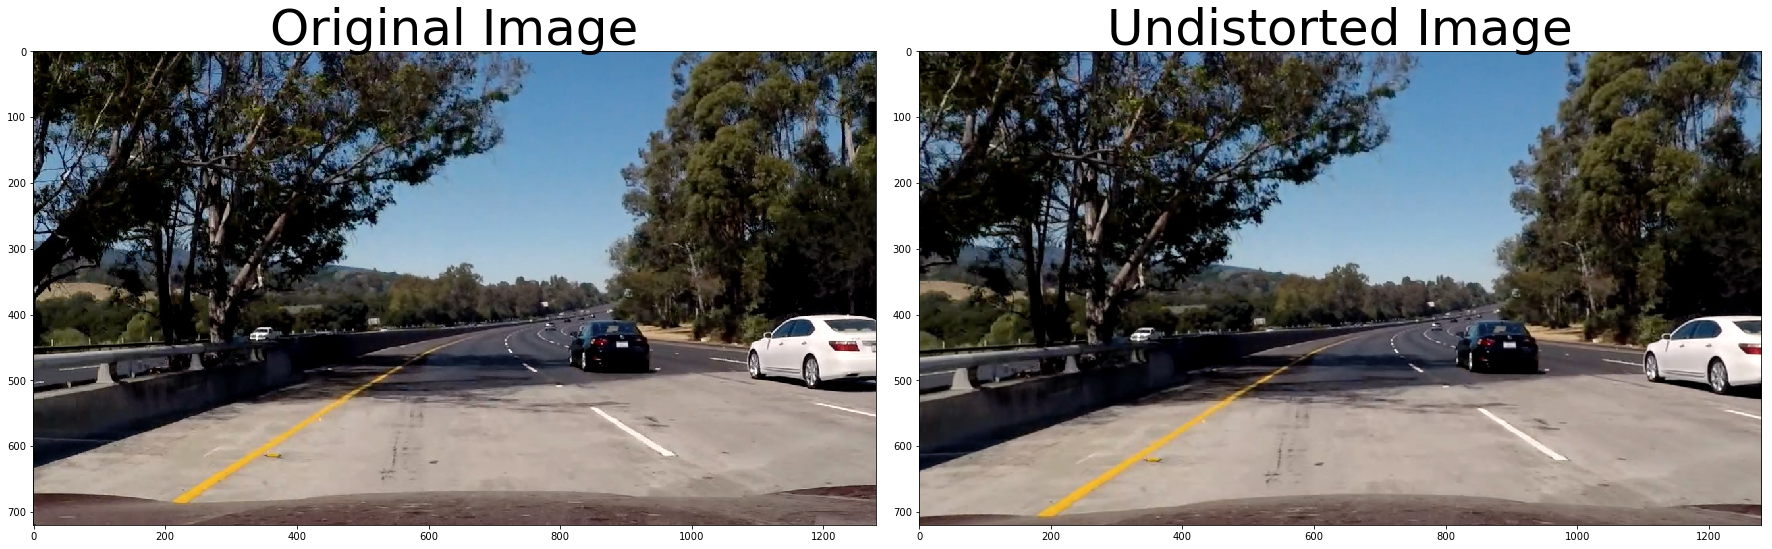

In [3]:
#test high image distortion correction 
fname2 = 'test_images/test5.jpg'
img = mpimg.imread(fname2)
undistorted=cv2.undistort(img, mtx, dist, None, mtx)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/Undistorted.png')#savefig method

In [2]:
def combine_gradient_HLS(img, s_thresh=(170, 255), sobel_kernel=3,sx_thresh=(20, 100),sy_thresh=(20, 100),
                         mag_thresh=(30, 100),dir_thresh=(0.7, 1.3)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0,ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Sobel y
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1,ksize=sobel_kernel) # Take the derivative in y
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from horizontal
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))

    # Sobel Magnitude
    mag_sobel = np.sqrt(np.square(sobelx)+np.square(sobely))
    scaled_mag_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    
    # Sobel Direction
    dir_sobel = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    scaled_dir_sobel = np.uint8(255*dir_sobel/np.max(dir_sobel))
    
    
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx<= sx_thresh[1])] = 1
    
    # Threshold y gradient
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= sy_thresh[0]) & (scaled_sobely <= sy_thresh[1])] = 1    
    
    # Threshold Sobel Magnitude
    s_mag_binary = np.zeros_like(scaled_mag_sobel)
    s_mag_binary[(scaled_mag_sobel >= mag_thresh[0]) & (scaled_mag_sobel <= mag_thresh[1])] = 1    
    
    # Threshold Sobel Direction
    s_dir_binary = np.zeros_like(scaled_dir_sobel)
    s_dir_binary[(scaled_dir_sobel >= dir_thresh[0]) & (scaled_dir_sobel <= dir_thresh[1])] = 1     
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    #combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    combined_binary[((sxbinary == 1) & (sybinary == 1)) | ((s_mag_binary == 1)& (s_dir_binary == 1))|(s_binary == 1) ] = 1
    #return color_binary[:,:,2]
    return combined_binary


In [3]:
def perspective_transformed_img(img, src, dst, mtx, dist,show=False):
    '''
    Applied undistorted function here
    '''
    undistorted=cv2.undistort(img, mtx, dist, None, mtx)
    img_size=(img.shape[1],img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped= cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)
    if show:
        pts = np.array([(570, 470),(722, 470),(1027.79,676.525),(279.837,676.525)], np.int32)
        #pts = np.array([(530.169,500.677),(758.717,500.675),(1027.79,676.525),(279.837,676.525)], np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(undistorted,[pts],True,(255,0,0))
        #cv2.polylines(undistorted,[pts],True,(1,0))
    
    return warped, M




In [4]:
def region_of_interest(img, show=False):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count #?????
    else:
        ignore_mask_color = 255
        
    vertices = np.array([[(100,img.shape[0]),(img.shape[1]/2.0-50, img.shape[0]/2.0), (img.shape[1]/2.0+50, img.shape[0]/2.0), (img.shape[1]-50,img.shape[0])]], dtype=np.int32)
    #vertices = np.array([[(100,img.shape[0]),(img.shape[1]/2.0-50, img.shape[0]/2.5), (img.shape[1]/2.0+150, img.shape[0]/2.5), (img.shape[1],img.shape[0])]], dtype=np.int32)
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [5]:
#src=np.float32([(626.455,432.508),(651.9,432.508),(1027.79,676.525),(279.837,676.525)])
#src=np.float32([(597.34,451.554),(684.386,451.554),(1027.79,676.525),(279.837,676.525)])
#src=np.float32([(530.169,500.677),(758.717,500.675),(1027.79,676.525),(279.837,676.525)])
#dst=np.float32([(223,0),(1093,0),(1093,720),(223,720)])
#src=np.float32([(620,437),(660,437),(1093,720),(223,720)])
#offset=100
#dst=np.float32([(223+offset+0,0+offset),(1093-offset,0+offset),(1093-offset-0,720-offset),(223+offset,720-offset)])
#dst = np.float32([[offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])
src=np.float32([(570, 470),(722, 470),(1027.79,676.525),(279.837,676.525)])
dst=np.float32([(223,0),(893,0),(893,720),(223,720)])
#dst=np.float32([(223,0),(1093,0),(1093,720),(223,720)])



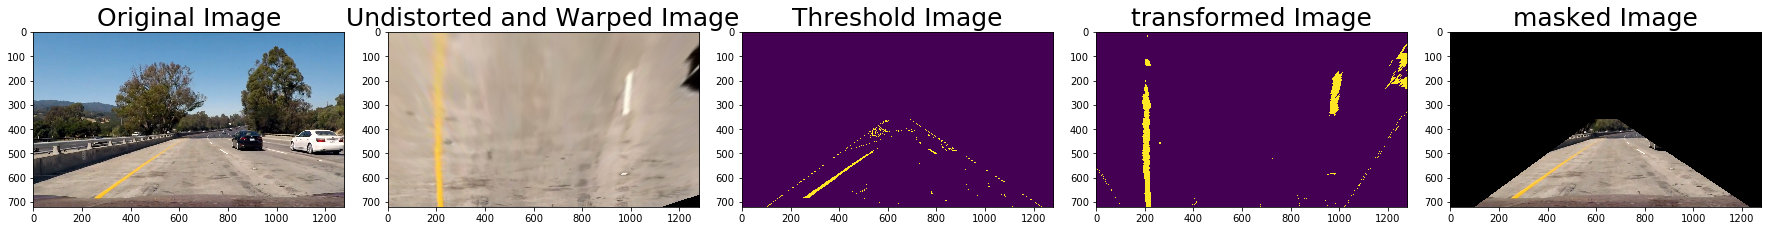

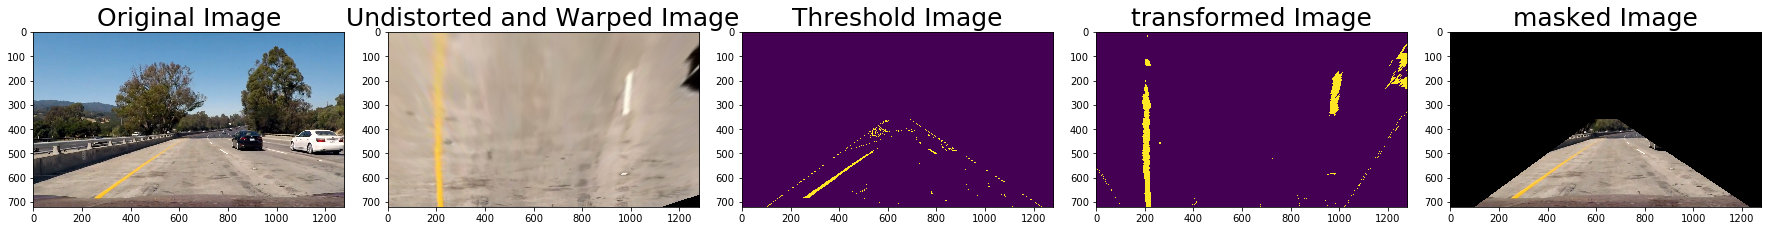

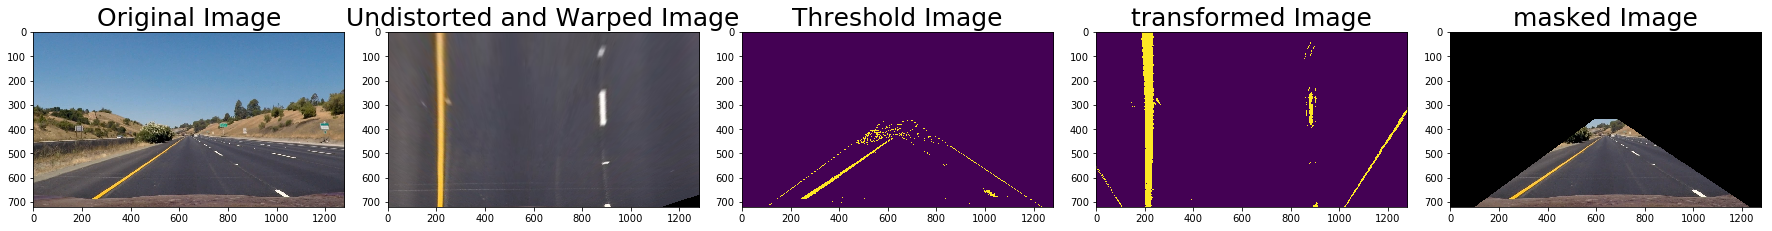

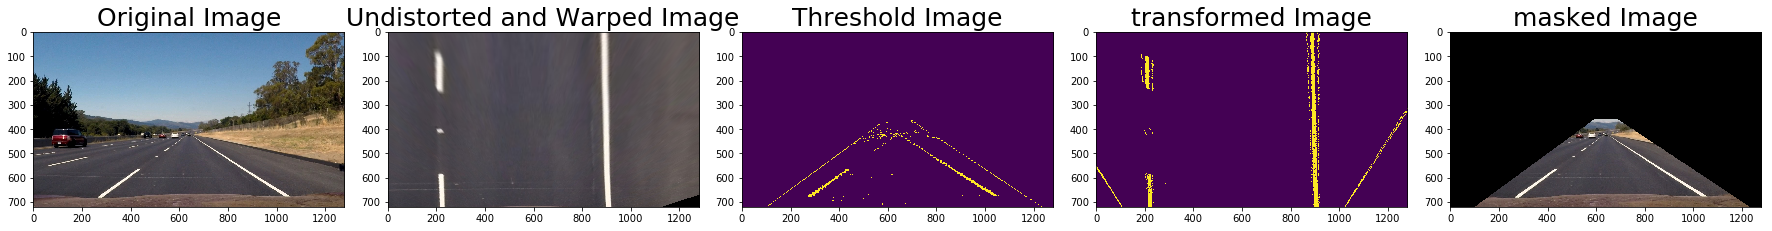

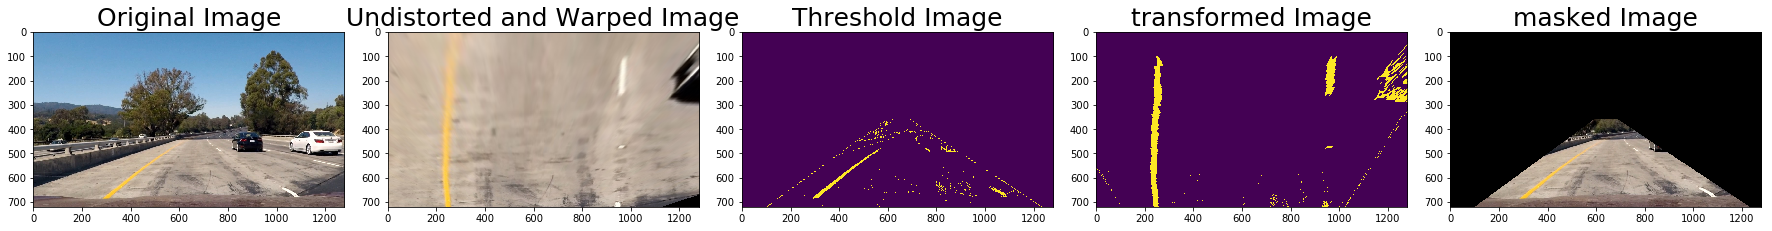

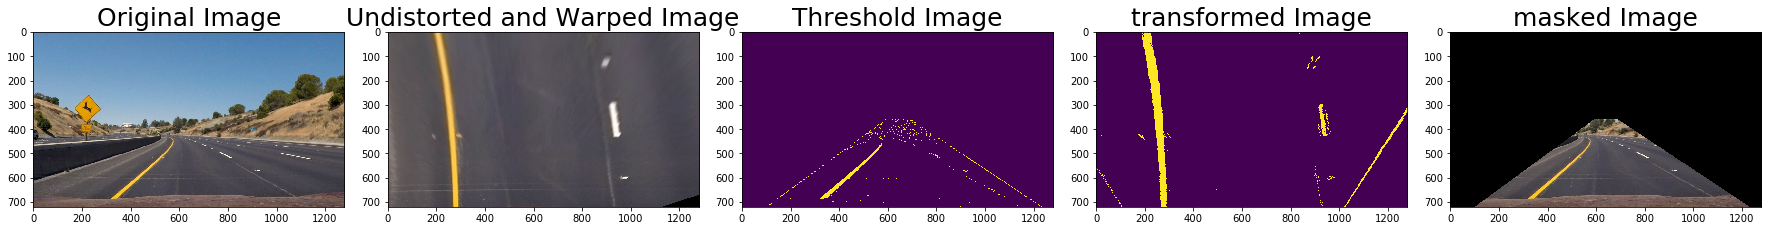

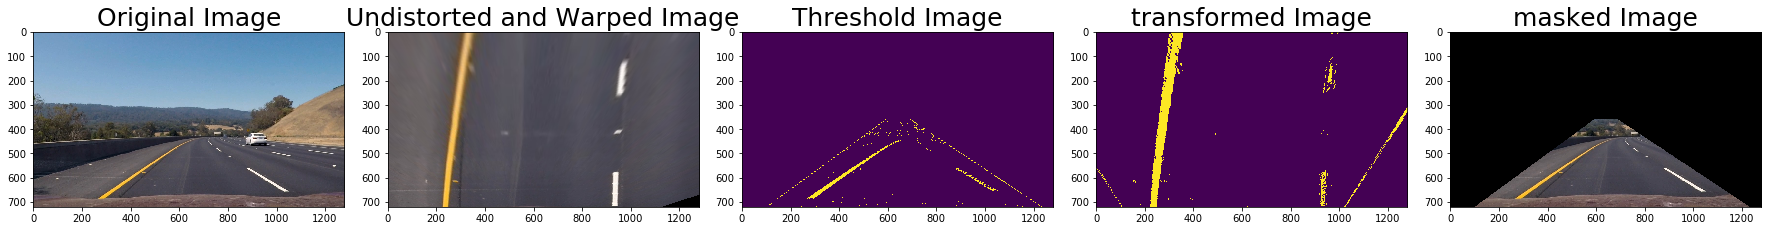

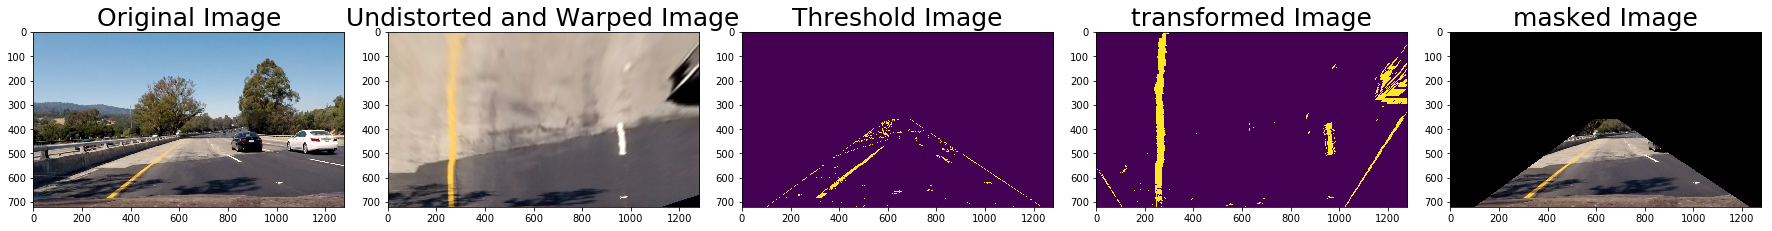

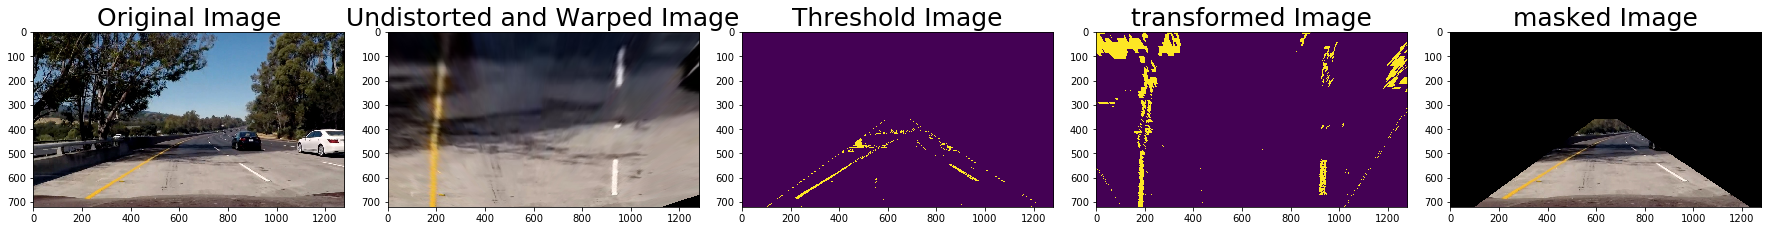

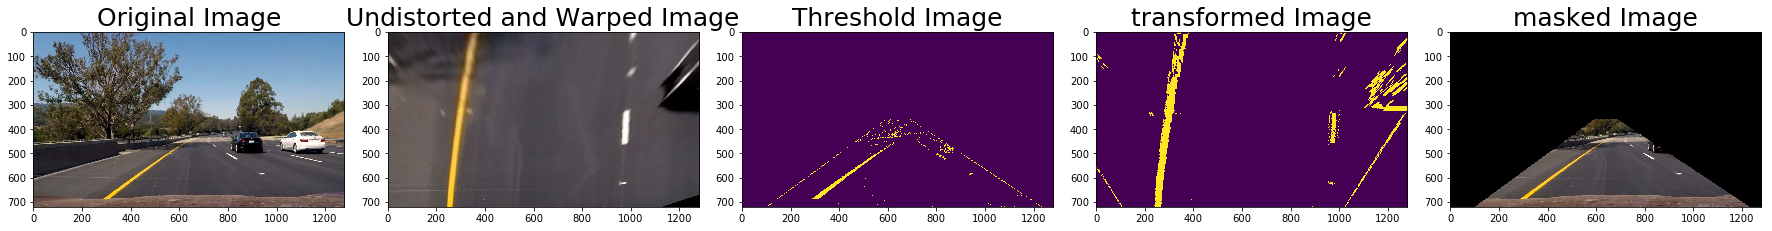

In [6]:
fnames=glob.glob('test_images/*.jpg')

for fname in fnames:
    img = mpimg.imread(fname)
    warped_img, perspective_M = perspective_transformed_img(img, src, dst, mtx, dist,show=True)
    region_img=region_of_interest(img)
    combined_img = combine_gradient_HLS(region_img)
    transformed_img, perspective_M = perspective_transformed_img(combined_img, src, dst, mtx, dist)

    f, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1, 5, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(warped_img)
    ax2.set_title('Undistorted and Warped Image', fontsize=25)
    ax3.imshow(combined_img)
    ax3.set_title('Threshold Image', fontsize=25)
    ax4.imshow(transformed_img)
    ax4.set_title('transformed Image', fontsize=25)
    ax5.imshow(region_img)
    ax5.set_title('masked Image', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/Fianl.png')

In [12]:
print(fnames )

['test_images/mpv-shot0002.jpg', 'test_images/mpv-shot0003.jpg', 'test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


(720, 1280)


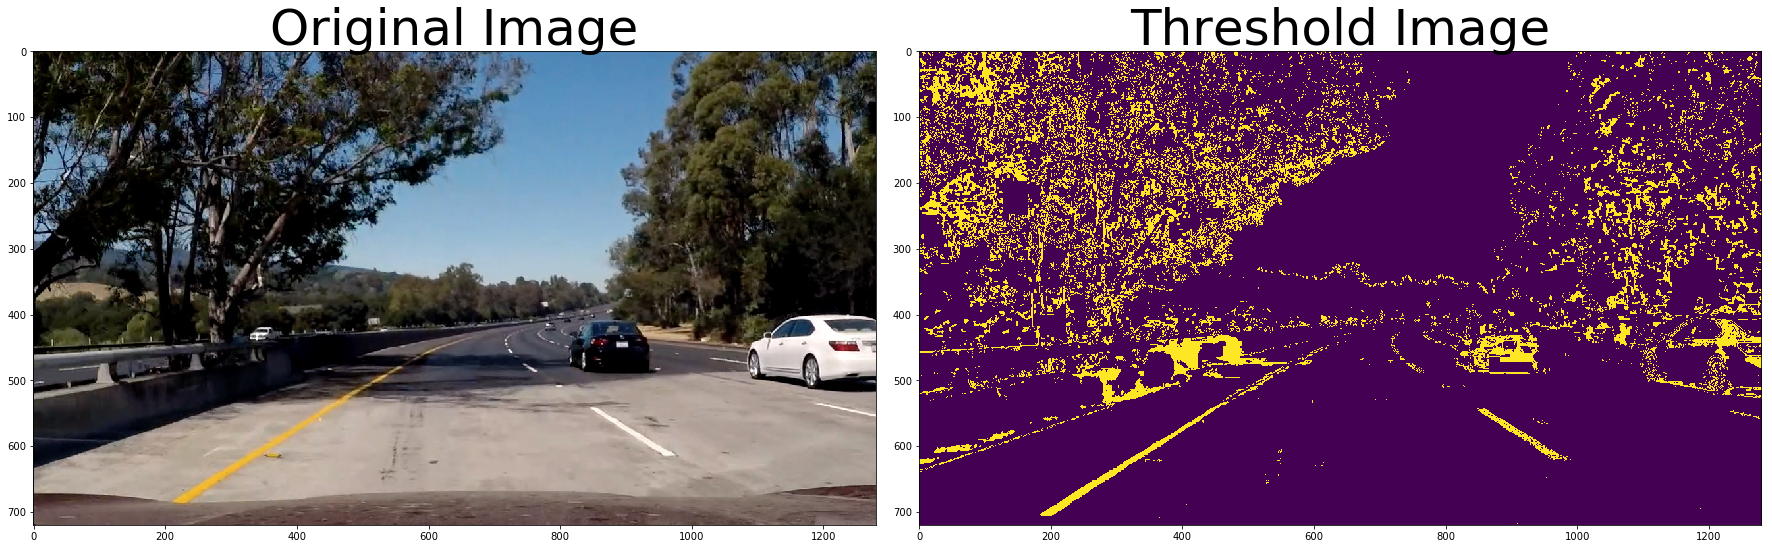

In [13]:
img2 = mpimg.imread(fnames[8])
undistorted_img2=cv2.undistort(img2, mtx, dist, None, mtx)
combined_img2 = combine_gradient_HLS(undistorted_img2)
transformed_img2, perspective_M = perspective_transformed_img(combined_img2, src, dst, mtx, dist)

print(transformed_img2.shape)
f, (ax1, ax2) = plt.subplots(1, 2,  figsize=(24, 9))
f.tight_layout()
ax1.imshow(img2)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_img2)
ax2.set_title('Threshold Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/Threshold.png')#savefig method

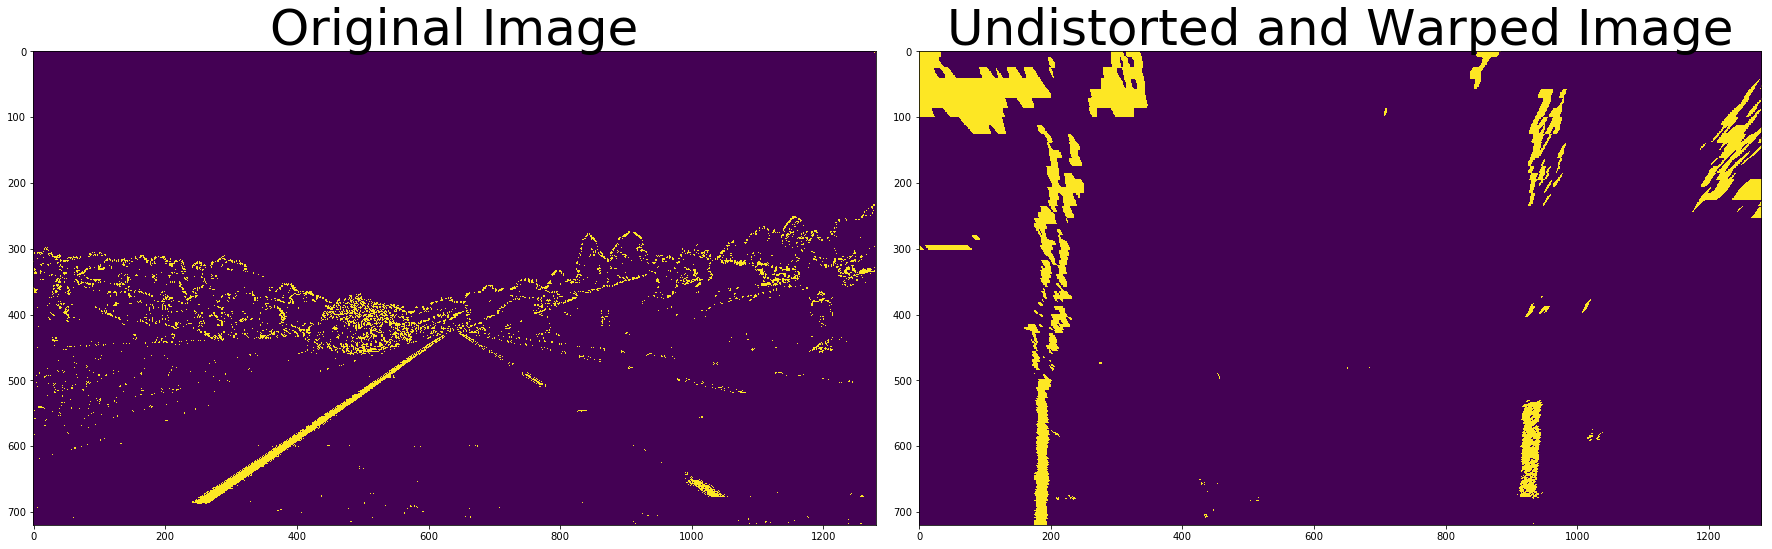

In [16]:
img3 = mpimg.imread(fnames[2])
#undistorted_img3=cv2.undistort(img3, mtx, dist, None, mtx)
combined_img3 = combine_gradient_HLS(img3)
transformed_img3, perspective_M = perspective_transformed_img(combined_img2, src, dst, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_img3)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(transformed_img3)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

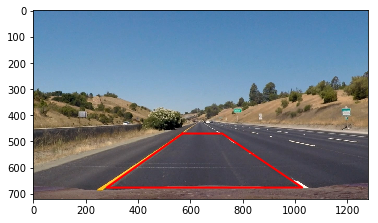

In [17]:
img3 = mpimg.imread(fnames[2])
plt.imshow(img3)
x = [src[0][0], src[1][0], src[2][0],src[3][0],src[0][0]]
y = [src[0][1], src[1][1], src[2][1],src[3][1],src[0][1]]
plt.plot(x, y, 'r', lw=2)


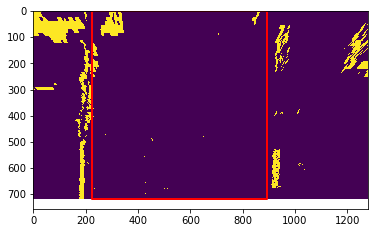

In [18]:
plt.imshow(transformed_img3)
x = [dst[0][0], dst[1][0], dst[2][0],dst[3][0],dst[0][0]]
y = [dst[0][1], dst[1][1], dst[2][1],dst[3][1],dst[0][1]]
plt.plot(x, y, 'r', lw=2)


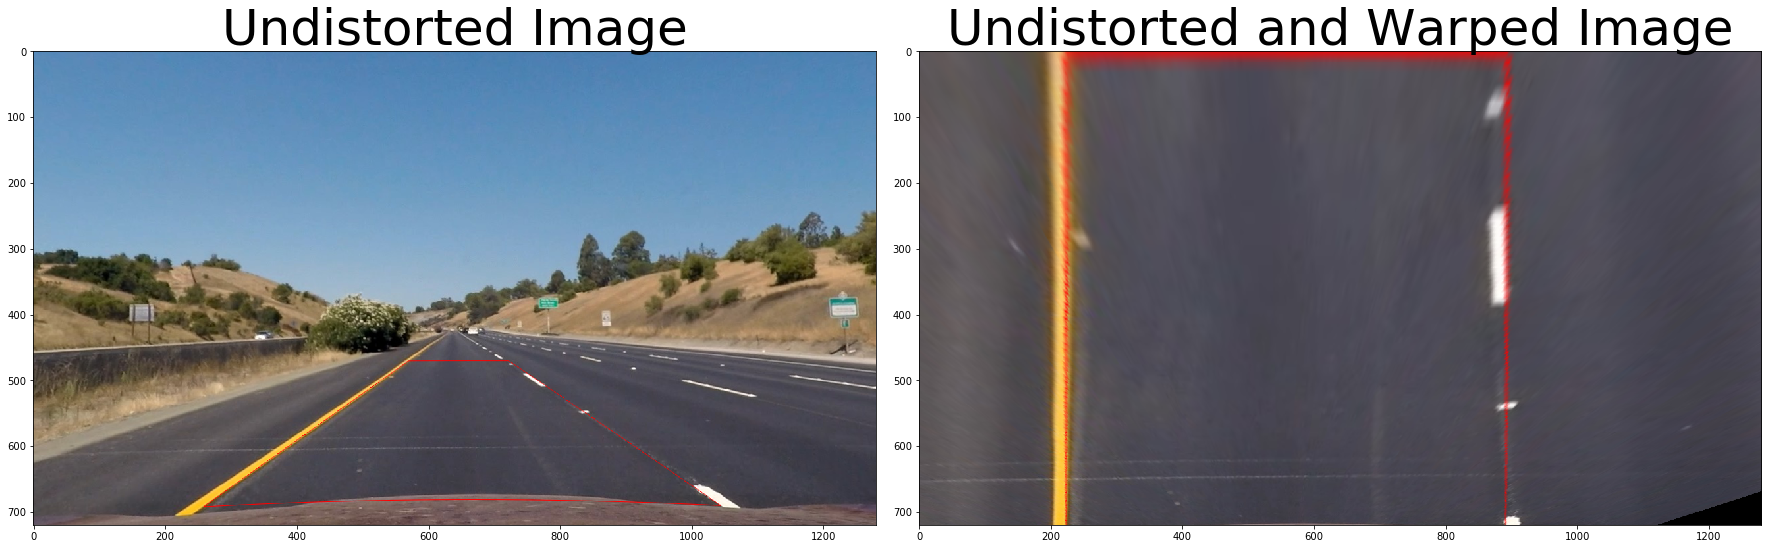

In [19]:
pts = np.array([(570, 470),(722, 470),(1027.79,676.525),(279.837,676.525)], np.int32)
#pts = np.array([(530.169,500.677),(758.717,500.675),(1027.79,676.525),(279.837,676.525)], np.int32)
pts = pts.reshape((-1,1,2))

copy = img3.copy()
cv2.polylines(copy,[pts],True,(255,0,0))

undistorted_copy3=cv2.undistort(copy, mtx, dist, None, mtx)
#cv2.polylines(undistorted_copy3,[pts],True,(255,0,0))
#combined_img3 = combine_gradient_HLS(undistorted_img3)
transformed_copy3, perspective_M = perspective_transformed_img(copy,src, dst,mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_copy3)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(transformed_copy3)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/Warped.png')#savefig method

In [7]:
def sliding_window_search(binary_img,show=False):
    histogram = np.sum(binary_img[img.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_img, binary_img, binary_img))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero_index = binary_img.nonzero()#return noezero pixel index
    nonzero_index_y = np.array(nonzero_index[0])#return noezero pixel y index :row index
    nonzero_index_x = np.array(nonzero_index[1])#return noezero pixel x index :column index
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices(index的复数)
    left_lane_indices = []
    right_lane_indices = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_img.shape[0] - (window+1)*window_height
        win_y_high = binary_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_indices = ((nonzero_index_y >= win_y_low) & (nonzero_index_y < win_y_high) & 
        (nonzero_index_x >= win_xleft_low) &  (nonzero_index_x < win_xleft_high)).nonzero()[0]
        good_right_indices = ((nonzero_index_y >= win_y_low) & (nonzero_index_y < win_y_high) & 
        (nonzero_index_x >= win_xright_low) &  (nonzero_index_x < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_indices.append(good_left_indices)
        right_lane_indices.append(good_right_indices)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_indices) > minpix:
            leftx_current = np.int(np.mean(nonzero_index_x[good_left_indices]))#return position(column index) of good_left_inds in nonzero_index_x
        if len(good_right_indices) > minpix:        
            rightx_current = np.int(np.mean(nonzero_index_x[good_right_indices]))

    # Concatenate the arrays of indices
    left_lane_indices = np.concatenate(left_lane_indices)
    right_lane_indices = np.concatenate(right_lane_indices)

    # Extract left and right line pixel positions(y,x)
    leftx = nonzero_index_x[left_lane_indices]
    lefty = nonzero_index_y[left_lane_indices] 
    rightx = nonzero_index_x[right_lane_indices]
    righty = nonzero_index_y[right_lane_indices] 

    # Fit a second order polynomial to each,return the coefficient of (a,b,c)
    left_fit_coefficient = np.polyfit(lefty, leftx, 2)
    right_fit_coefficient = np.polyfit(righty, rightx, 2)
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]    
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    
    
    #return two curves
    left_fitx = left_fit_coefficient[0]*ploty**2 + left_fit_coefficient[1]*ploty + left_fit_coefficient[2]
    right_fitx = right_fit_coefficient[0]*ploty**2 + right_fit_coefficient[1]*ploty + right_fit_coefficient[2]
    if show:
        #print(left_fit)
        #print(left_fitx)
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')# plot curves
        plt.plot(right_fitx, ploty, color='yellow')# plot curves
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    return out_img,left_fit_coefficient,right_fit_coefficient,left_fitx,right_fitx,ploty



[  2.98183020e-05  -1.23932833e-01   1.01161043e+03]


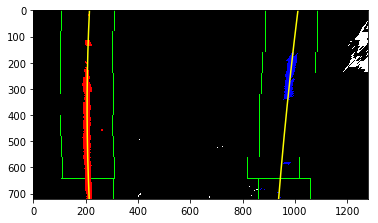

In [36]:
img = mpimg.imread(fnames[0])
combined_img = combine_gradient_HLS(img)
transformed_img, perspective_M = perspective_transformed_img(combined_img, src, dst, mtx, dist)

out_img,left_fit_coefficient,right_fit_coefficient,left_fitx,right_fitx,ploty=sliding_window_search(transformed_img)

left_fitx = left_fit_coefficient[0]*ploty**2 + left_fit_coefficient[1]*ploty + left_fit_coefficient[2]
right_fitx = right_fit_coefficient[0]*ploty**2 + right_fit_coefficient[1]*ploty + right_fit_coefficient[2]
print(right_fit_coefficient)
#print(left_fitx)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/slide_window_search_result.png')#savefig method

In [8]:
def around_search(binary_img,left_fit_coefficient,right_fit_coefficient):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_img")
    # It's now much easier to find line pixels!
    nonzero_index = binary_img.nonzero()
    nonzero_index_y = np.array(nonzero_index[0])
    nonzero_index_x = np.array(nonzero_index[1])
    margin = 100
    left_lane_indices = ((nonzero_index_x > (left_fit_coefficient[0]*(nonzero_index_y**2) + left_fit_coefficient[1]*nonzero_index_y + 
    left_fit_coefficient[2] - margin)) & (nonzero_index_x < (left_fit_coefficient[0]*(nonzero_index_y**2) + 
    left_fit_coefficient[1]*nonzero_index_y + left_fit_coefficient[2] + margin))) 

    right_lane_indices = ((nonzero_index_x > (right_fit_coefficient[0]*(nonzero_index_y**2) + right_fit_coefficient[1]*nonzero_index_y + 
    right_fit_coefficient[2] - margin)) & (nonzero_index_x < (right_fit_coefficient[0]*(nonzero_index_y**2) + 
    right_fit_coefficient[1]*nonzero_index_y + right_fit_coefficient[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzero_index_x[left_lane_indices]
    lefty = nonzero_index_y[left_lane_indices] 
    rightx = nonzero_index_x[right_lane_indices]
    righty = nonzero_index_y[right_lane_indices]
    # Fit a second order polynomial to each
    left_fit_coefficient = np.polyfit(lefty, leftx, 2)
    right_fit_coefficient = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    #return two curves
    left_fitx = left_fit_coefficient[0]*ploty**2 + left_fit_coefficient[1]*ploty + left_fit_coefficient[2]
    right_fitx = right_fit_coefficient[0]*ploty**2 + right_fit_coefficient[1]*ploty + right_fit_coefficient[2]



    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_img, binary_img, binary_img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]      
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))


    
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result,left_fit_coefficient,right_fit_coefficient,left_fitx,right_fitx,ploty


(720, 0)

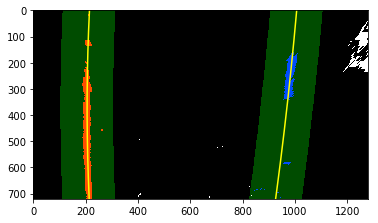

In [24]:
result,left_fit_coefficient,right_fit_coefficient,left_fitx,right_fitx,ploty=around_search(transformed_img,left_fit_coefficient,right_fit_coefficient)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [9]:
def measure_pixel_space_radius(left_fit,right_fit,ploty,show=False):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    if show:
        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        plt.plot(left_fitx, ploty, color='green', linewidth=3)
        plt.plot(right_fitx, ploty, color='green', linewidth=3)
        plt.gca().invert_yaxis() # to visualize as we do the images
    return left_curverad, right_curverad

''' convert to real world space radius'''
def measure_realworld_radius(left_fit,right_fit,ploty,show=False):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Calculate the new radii of curvature
    left_real_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_real_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # Now our radius of curvature is in meters
    #print(left_real_curverad, 'm', right_real_curverad, 'm')
    return left_real_curverad,right_real_curverad
    

In [30]:
left_curverad, right_curverad=measure_realworld_radius(left_fit_coefficient,right_fit_coefficient,ploty,show=True)
print(left_curverad, right_curverad)

7588.06169981 15684.8812754


In [10]:
def fill_lanes(img,src,dst,left_fitx,right_fitx,ploty,left_fit,right_fit,show=False):
    color_warp=np.zeros_like(img).astype(np.uint8)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    #Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    #font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    font = cv2.FONT_HERSHEY_SIMPLEX
    #cv2.putText(img,'Left curve' + ' ' + str(left_curverad)[:6] + 'm',(10,60), font, 1,(255,255,255),1)
    
    real_radius=measure_realworld_radius(left_fit,right_fit,ploty,show=False)
    average_radius=(real_radius[0]+real_radius[1])/2.0
    
    # Calculate the vehicle position offset to the lane center
    left_bottom = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    right_bottom= right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    position = (left_bottom+right_bottom)/2.0
    #offset = abs((640 - position)*3.7/700) 
    offset = (640 - position)*3.7/700
    
    
    cv2.putText(img,'radius of curvature' +'[' +str(average_radius)[:6] + '] m' ,(10,60), font, 1,(255,255,255),2)
    cv2.putText(img,'vehicle position offset' +'[' +str(offset)[:6] + '] m' ,(10,100), font, 1,(255,255,255),2)
    #cv2.putText(img,'vehicle position offset' +'[' +str(right_bottom)[:6] + '] m' ,(10,140), font, 1,(255,255,255),2)
    
    
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    return result


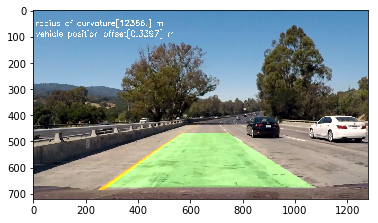

In [37]:
result=fill_lanes(img,src,dst,left_fitx,right_fitx,ploty,left_fit_coefficient,right_fit_coefficient)

plt.imshow(result)
plt.savefig('output_images/fill_result.png')#savefig method

In [39]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
 
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        

        # was the line detected in the last iteration?
        self.detected = False        
        #line pixel positions(y,x)
        self.x=[]
        self.y=[]
        self.x_list=[]
        self.y_list=[]
        self.x_avg=None
        self.y_avg=None
        #polynomial coefficients of the last frame
        self.fit_coefficient=[]
        #a list of polynomial coefficients of the last num_frames frames
        self.polyfit=[]
        #average polynomial coefficients of the last num_frames frames
        self.average_fit=[]
        
        self.fitx=[]
        self.bottom=[]
        

    def window(self, binary_img):
        histogram = np.sum(binary_img[img.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        if self==left:
            x_base = np.argmax(histogram[:midpoint])
        else:
            x_base = np.argmax(histogram[midpoint:]) + midpoint
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_img.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero_index = binary_img.nonzero()#return noezero pixel index
        nonzero_index_y = np.array(nonzero_index[0])#return noezero pixel y index :row index
        nonzero_index_x = np.array(nonzero_index[1])#return noezero pixel x index :column index
        # Current positions to be updated for each window
        x_current = x_base
    
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Create empty lists to receive left and right lane pixel indices(index的复数)
        lane_indices = []


        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_img.shape[0] - (window+1)*window_height
            win_y_high = binary_img.shape[0] - window*window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin
            
            # Identify the nonzero pixels in x and y within the window
            good_lane_indices = ((nonzero_index_y >= win_y_low) & (nonzero_index_y < win_y_high) & 
            (nonzero_index_x >= win_x_low) &  (nonzero_index_x < win_x_high)).nonzero()[0]

            # Append these indices to the lists
            lane_indices.append(good_lane_indices)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_lane_indices) > minpix:
                leftx_current = np.int(np.mean(nonzero_index_x[good_lane_indices]))#return position(column index) of good_left_inds in nonzero_index_x


        # Concatenate the arrays of indices
        lane_indices = np.concatenate(lane_indices)

        # Extract left and right line pixel positions(y,x)
        x = nonzero_index_x[lane_indices]
        y = nonzero_index_y[lane_indices] 

        new_fit_coefficient = np.polyfit(y, x, 2)
    
        new_bottom= new_fit_coefficient[0]*720**2 + new_fit_coefficient[1]*720 + new_fit_coefficient[2]

        #if self.x_avg !=None
        #if self.bottom!=[]:
        if self.fit_coefficient !=[]:
            #if (abs(new_fit_coefficient[2]-self.fit_coefficient[2])<1000):
            if len(x)!=0:
            #if abs(new_bottom-self.bottom)<500:
                self.detected=True
            else:
                #x=self.x
                #y=self.y
                new_fit_coefficient=self.average_fit
                new_bottom=self.bottom


        return self.detected,x,y,new_fit_coefficient,new_bottom
            
    def around(self, binary_img,fit_coefficient):        
        
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_img")
        # It's now much easier to find line pixels!
        nonzero_index = binary_img.nonzero()
        nonzero_index_y = np.array(nonzero_index[0])
        nonzero_index_x = np.array(nonzero_index[1])
        margin = 100
        lane_indices = ((nonzero_index_x > (fit_coefficient[0]*(nonzero_index_y**2) + fit_coefficient[1]*nonzero_index_y + 
        fit_coefficient[2] - margin)) & (nonzero_index_x < (fit_coefficient[0]*(nonzero_index_y**2) + 
        fit_coefficient[1]*nonzero_index_y + fit_coefficient[2] + margin))) 

        # Again, extract left and right line pixel positions
        x = nonzero_index_x[lane_indices]
        y = nonzero_index_y[lane_indices] 

        new_fit_coefficient = np.polyfit(y, x, 2)
        new_bottom= new_fit_coefficient[0]*720**2 + new_fit_coefficient[1]*720 + new_fit_coefficient[2]
        
        #if np.sum(x)<=90000:
        if self.fit_coefficient !=[]:
        #if self.bottom!=[]:
            #if (abs(new_fit_coefficient[2]-self.average_fit[2])>30):
            #if abs(new_bottom-self.bottom)>20:
            if (len(x)-self.x_avg)<-1000:
                self.detected=False
                #x=self.x
                #y=self.y
                new_fit_coefficient=self.average_fit
                new_bottom=self.bottom
            
        return self.detected,x,y,new_fit_coefficient,new_bottom

left = Line()
right=Line()       

In [40]:
def process_image(img):
    
    #region_img=region_of_interest(img)
    #combined_img = combine_gradient_HLS(region_img)
    combined_img = combine_gradient_HLS(img)
    transformed_img, perspective_M = perspective_transformed_img(combined_img, src, dst, mtx, dist)
        
    num_frames = 10
    ploty=np.linspace(0, 719,720 )

    if left.detected==True:
        left.detected,left.x,left.y,left.fit_coefficient,left.bottom=left.around(transformed_img,left.average_fit)               
    if right.detected==True:
        right.detected,right.x,right.y,right.fit_coefficient,right.bottom=right.around(transformed_img,right.average_fit)
    if left.detected==False:
        left.detected,left.x,left.y,left.fit_coefficient,left.bottom=left.window(transformed_img)
    if right.detected==False:
        right.detected,right.x,right.y,right.fit_coefficient,right.bottom=right.window(transformed_img) 

        
    if (0<=len(left.polyfit)< num_frames):
        left.polyfit.append(left.fit_coefficient)
        left.x_list.append(len(left.x))
        left.y_list.append(len(left.y))

        
    else:
        left.polyfit[0:num_frames-1] = left.polyfit[1:]
        left.polyfit[num_frames-1] = left.fit_coefficient
        
        del left.x_list[0]
        del left.y_list[0]
        left.x_list.append(len(left.x))
        left.y_list.append(len(left.y))
        
    if (0<=len(right.polyfit)< num_frames):
        right.polyfit.append(right.fit_coefficient)
        right.x_list.append(len(right.x))
        right.y_list.append(len(right.y))        
    else:
        del right.polyfit[0]
        right.polyfit.append(right.fit_coefficient)
        del right.x_list[0]
        del right.y_list[0]
        right.x_list.append(len(right.x))
        right.y_list.append(len(right.y))  
        
    left.x_avg=np.mean(left.x_list)
    right.x_avg=np.mean(right.x_list)
    
    # average over the last num_frames frames
    left.average_fit=np.mean(np.array(left.polyfit),axis=0)
    right.average_fit=np.mean(np.array(right.polyfit),axis=0)
    
    left.fitx = left.average_fit[0]*ploty**2 + left.average_fit[1]*ploty + left.average_fit[2]
    right.fitx = right.average_fit[0]*ploty**2 + right.average_fit[1]*ploty + right.average_fit[2]
    final=fill_lanes(img,src,dst,left.fitx,right.fitx,ploty,left.average_fit,right.average_fit)
    return final

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [41]:

#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")#.subclip(39,44.5)
#clip1 = VideoFileClip("project_video.mp4")

#clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image)

lanes_video = 'result.mp4'
%time white_clip.write_videofile(lanes_video, audio=False)



[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [06:45<00:00,  3.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 4min 52s, sys: 2min 17s, total: 7min 9s
Wall time: 6min 47s


In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(lanes_video))